# Multi-Modal Models Data Analysis

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from skimage import color
from torchvision import transforms
import torchvision.models as models
import ast
import time
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from collections import defaultdict
import seaborn as sns

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Transformations

In [3]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

## Dataset

In [4]:
class FundusDataset_MM(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        left_img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 3])
        right_img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 4])

        left_image = io.imread(left_img_name)
        right_image = io.imread(right_img_name)

        if len(left_image.shape) > 2 and left_image.shape[2] == 4:
            left_image = left_image[:, :, 0]
        if len(right_image.shape) > 2 and right_image.shape[2] == 4:
            right_image = right_image[:, :, 0]

        if left_image.shape[-1] != 3:
            left_image = np.repeat(left_image[:, :, np.newaxis], 3, axis=2)
        if right_image.shape[-1] != 3:
            right_image = np.repeat(right_image[:, :, np.newaxis], 3, axis=2)

        image_class = self.data_frame.iloc[idx, -1]
        image_class = ast.literal_eval(image_class)
        image_class = torch.tensor(image_class, dtype=torch.int64)
        one_hot_image_class = F.one_hot(image_class, num_classes=2).squeeze(0)

        # Tabular patient data
        age_gender = self.data_frame.iloc[idx, 1:3] # age and gender
        age_gender = torch.tensor(age_gender, dtype=torch.float32)

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)

        if left_image.dim() == 2:
            left_image = left_image.unsqueeze(0)
        if right_image.dim() == 2:
            right_image = right_image.unsqueeze(0)

        sample = {'left_image': left_image, 'right_image': right_image, 'age_gender': age_gender, 'class': one_hot_image_class}

        return sample


## Dataloading

In [5]:
# Set csv file paths for training
train_info_path = r'./OIA-ODIR/Training Set/Annotation/training_annotation_filtered_OHE.csv'
valid_info_path = r'./OIA-ODIR/Off-site Test Set/Annotation/validation_annotation_filtered_OHE.csv'
test_info_path = r'./OIA-ODIR/On-site Test Set/Annotation/testing_annotation_filtered_OHE.csv'

# Set root directory paths
train_root_dir = r'./OIA-ODIR/Training Set/Images'
valid_root_dir = r'./OIA-ODIR//Off-site Test Set/Images'
test_root_dir = r'./OIA-ODIR/On-site Test Set/Images'

# Transformed dataset for left and right fundus
transformed_dataset = {
    'train': FundusDataset_MM(csv_file=train_info_path, root_dir=train_root_dir, transform=transform),
    'validate': FundusDataset_MM(csv_file=valid_info_path, root_dir=valid_root_dir, transform=transform),
    'test': FundusDataset_MM(csv_file=test_info_path, root_dir=test_root_dir, transform=transform)
}

## Model 1: Late Fusion (SUM)

In [6]:
class LateFusionSUM_MM_Resnet18(nn.Module):
    def __init__(self):
        super(LateFusionSUM_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()
        self.fc_image = nn.Linear(num_image_features, 512)  # Fusion layer for image features
        self.fc_tabular = nn.Linear(2, 64)  # Fusion layer for tabular features
        self.fc_final = nn.Linear(512 + 64, 512)  # Fusion layer for combined features
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        left_features = self.resnet18(left)
        right_features = self.resnet18(right)
        
        # Combine image features using element-wise sum
        fused_image_features = left_features + right_features
        fused_image_features = self.fc_image(fused_image_features)
        
        # tabular features
        tabular_features = self.fc_tabular(age_gender)
        
        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)
        
        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)


## Model 2: Late Fusion (CONCAT)

In [7]:
class LateFusionCONCAT_MM_Resnet18(nn.Module):
    def __init__(self):
        super(LateFusionCONCAT_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer
        self.fc_image = nn.Linear(num_image_features * 2, 512)  # Fusion layer
        self.fc_tabular = nn.Linear(2, 64)
        self.fc_final = nn.Linear(512 + 64, 512)
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        left_features = self.resnet18(left)
        right_features = self.resnet18(right)
        fused_image_features = torch.cat((left_features, right_features), dim=1)  # concat features late fusion
        fused_image_features = self.fc_image(fused_image_features)

        # tabular features
        tabular_features = self.fc_tabular(age_gender)
        
        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)
        
        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)

## Model 3: Late Fusion (PROD)

In [8]:
class LateFusionPROD_MM_Resnet18(nn.Module):
    def __init__(self):
        super(LateFusionPROD_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer
        self.fc_image = nn.Linear(num_image_features, 512)  # Fusion layer
        self.fc_tabular = nn.Linear(2, 64)  # Fusion layer for tabular features
        self.fc_final = nn.Linear(512 + 64, 512)
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        left_features = self.resnet18(left)
        right_features = self.resnet18(right)
        fused_image_features = left_features * right_features  # Element-wise product fusion
        fused_image_features = self.fc_image(fused_image_features)

        # tabular features
        tabular_features = self.fc_tabular(age_gender)

        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)
        
        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)

## Model 4: Early Fusion (SUM)

In [9]:
class EarlyFusionSUM_MM_Resnet18(nn.Module):
    def __init__(self):
        super(EarlyFusionSUM_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer
        self.fc_image = nn.Linear(num_image_features, 512)  # Fusion layer for image features
        self.fc_tabular = nn.Linear(2, 64)  # Fusion layer for tabular features
        self.fc_final = nn.Linear(512 + 64, 512)  # Fusion layer for combined features
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        summed_input = left + right # Element-wise summation
        fused_image_features = self.resnet18(summed_input)
        fused_image_features = self.fc_image(fused_image_features)
        
        # tabular features
        tabular_features = self.fc_tabular(age_gender)

        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)

        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)

## Model 5: Early Fusion (CONCAT)

In [10]:
class EarlyFusionCONCAT_MM_Resnet18(nn.Module):
    def __init__(self):
        super(EarlyFusionCONCAT_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        self.resnet18.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False) # To accomodate concat early fusion
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()
        self.fc_image = nn.Linear(num_image_features, 512)  # Fusion layer for image features
        self.fc_tabular = nn.Linear(2, 64)  # Fusion layer for tabular features
        self.fc_final = nn.Linear(512 + 64, 512)  # Fusion layer for combined features
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        fused_input = torch.cat((left, right), dim=1) 
        fused_image_features = self.resnet18(fused_input)
        fused_image_features = self.fc_image(fused_image_features)

        # tabular features
        tabular_features = self.fc_tabular(age_gender)

        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)

        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)


## Model 6: Early Fusion (PROD)

In [11]:
class EarlyFusionPROD_MM_Resnet18(nn.Module):
    def __init__(self):
        super(EarlyFusionPROD_MM_Resnet18, self).__init__()
        self.resnet18 = models.resnet18(weights='DEFAULT')
        num_image_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the fully connected layer
        self.fc_image = nn.Linear(num_image_features, 512)  # Fusion layer for image features
        self.fc_tabular = nn.Linear(2, 64)  # Fusion layer for tabular features
        self.fc_final = nn.Linear(512 + 64, 512)  # Fusion layer for combined features
        self.classifiers = nn.ModuleList([nn.Linear(512, 2) for _ in range(8)])  # 8 classifiers for multi-label classification
        
    def forward(self, left, right, age_gender):
        fused_input = left * right # Element-wise product
        fused_image_features = self.resnet18(fused_input)
        fused_image_features = self.fc_image(fused_image_features)
        
        # tabular features
        tabular_features = self.fc_tabular(age_gender)

        # Concatenate image and tabular features
        combined_features = torch.cat((fused_image_features, tabular_features), dim=1)
        combined_features = self.fc_final(combined_features)

        outputs = [classifier(combined_features) for classifier in self.classifiers]
        return torch.stack(outputs, dim=1)

In [12]:
# Load Saved Models and Compute Per Class and Average AUC for Valid and Test
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

torch.manual_seed(42)
np.random.seed(42)

def eval_model(model, dataloader, verbose=True):
    kappa_dict = {'validate': [], 'test':[]}
    f1_dict = {'validate': [], 'test':[]}
    auc_dict = {'validate': [], 'test':[]}
    per_class_auc_dict = {'validate': [], 'test':[]}
    fpr_dict = {'validate': [], 'test':[]}
    tpr_dict = {'validate': [], 'test':[]}
    thresh_dict = {'validate': [], 'test':[]}
    best_f1 = 0
    phases = ['validate', 'test']
    model.eval()
    for p in phases:
        all_probabilities_pos = []
        all_predictions = []
        all_labels = []
        all_labels_pos = []

        with torch.no_grad():
            for data in dataloader[p]:
                left_images = data['left_image'].to(device)
                right_images = data['right_image'].to(device)
                age_gender = data['age_gender'].to(device)
                labels = data['class'].to(device)
                outputs = model(left_images, right_images, age_gender)
                num_classifiers = outputs.size(1)
                
                probabilities = torch.sigmoid(outputs)
                probabilities_pos = probabilities[:, :, 1]
                
                labels_pos = labels[:, :, 1]
                
                predictions = (probabilities > 0.5).int()
                
                all_probabilities_pos.extend(probabilities_pos.cpu().detach())
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_labels_pos.extend(labels_pos.cpu().detach())
        if verbose or (i%10 == 0):
            print('Phase:{}'.format(p))  
        if p == 'validate':
            all_labels_flat = np.concatenate(all_labels).flatten()
            all_predictions_flat = np.concatenate(all_predictions).flatten()
            stacked_labels_pos = torch.stack(all_labels_pos, dim=0)
            reshaped_labels_pos = stacked_labels_pos.view(stacked_labels_pos.shape[0], -1)
            stacked_prob_pos = torch.stack(all_probabilities_pos, dim=0)
            reshaped_prob_pos = stacked_prob_pos.view(stacked_prob_pos.shape[0], -1)
            reshaped_labels_pos = reshaped_labels_pos.numpy()
            reshaped_prob_pos = reshaped_prob_pos.numpy()

            fpr = {}
            tpr = {}
            thresholds = {}
            for i in range(8):
                fpr[i], tpr[i], thresholds[i] = roc_curve(reshaped_labels_pos[:, i], reshaped_prob_pos[:, i])
            
            class_auc_scores = {}
            for i in range(8):
                class_auc_scores[i] = auc(fpr[i], tpr[i])

            valid_auc_scores = [auc_score for auc_score in class_auc_scores.values() if not np.isnan(auc_score)]
            macro_auc_score = np.mean(valid_auc_scores)
            
            kappa = cohen_kappa_score(all_labels_flat, all_predictions_flat)
            f1 = f1_score(all_labels_flat, all_predictions_flat, average='macro')
            
            print('Kappa: {:.4f} F1: {:.4f} AUC: {:.4f}'.format(kappa, f1, macro_auc_score))
                
            kappa_dict[p].append(kappa)
            f1_dict[p].append(f1)
            auc_dict[p].append(macro_auc_score)
            per_class_auc_dict[p].append(class_auc_scores)
            fpr_dict[p].append(fpr)
            tpr_dict[p].append(tpr)
            thresh_dict[p].append(thresholds)

        if p == 'test':
            all_labels_flat = np.concatenate(all_labels).flatten()
            all_predictions_flat = np.concatenate(all_predictions).flatten()
            stacked_labels_pos = torch.stack(all_labels_pos, dim=0)
            reshaped_labels_pos = stacked_labels_pos.view(stacked_labels_pos.shape[0], -1)
            stacked_prob_pos = torch.stack(all_probabilities_pos, dim=0)
            reshaped_prob_pos = stacked_prob_pos.view(stacked_prob_pos.shape[0], -1)
            reshaped_labels_pos = reshaped_labels_pos.numpy()
            reshaped_prob_pos = reshaped_prob_pos.numpy()

            fpr = {}
            tpr = {}
            thresholds = {}
            for i in range(8):
                fpr[i], tpr[i], thresholds[i] = roc_curve(reshaped_labels_pos[:, i], reshaped_prob_pos[:, i])
            
            class_auc_scores = {}
            for i in range(8):
                class_auc_scores[i] = auc(fpr[i], tpr[i])

            valid_auc_scores = [auc_score for auc_score in class_auc_scores.values() if not np.isnan(auc_score)]
            macro_auc_score = np.mean(valid_auc_scores)
            
            kappa = cohen_kappa_score(all_labels_flat, all_predictions_flat)
            f1 = f1_score(all_labels_flat, all_predictions_flat, average='macro')
            
            print('Kappa: {:.4f} F1: {:.4f} AUC: {:.4f}'.format(kappa, f1, macro_auc_score))
                
            kappa_dict[p].append(kappa)
            f1_dict[p].append(f1)
            auc_dict[p].append(macro_auc_score)
            per_class_auc_dict[p].append(class_auc_scores)
            fpr_dict[p].append(fpr)
            tpr_dict[p].append(tpr)
            thresh_dict[p].append(thresholds)
    
    return kappa_dict, f1_dict, auc_dict, per_class_auc_dict, fpr_dict, tpr_dict, thresh_dict

In [30]:
saved_tab_models = ['LFS_MM.pt', 'LFC_MM.pt', 'LFP_MM.pt', 
                    'EFS_MM.pt', 'EFC_MM.pt', 'EFP_MM.pt']

saved_tab_results = ['LFS_MM.pkl', 'LFC_MM.pkl', 'LFP_MM.pkl', 
                       'EFS_MM.pkl', 'EFC_MM.pkl', 'EFP_MM.pkl']

In [23]:

bs = 16

kappa_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
f1_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
macro_auc_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
per_class_auc_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
fpr_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
tpr_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}
thresh_vals = {'LFS_MM': [], 'LFC_MM': [], 'LFP_MM': [], 'EFS_MM': [], 'EFC_MM': [], 'EFP_MM': []}

for model_file in saved_tab_models:
    model_name = model_file[:6]
    model_path = "./saved_models/bs_16_lr_1e-05/best_f1_score/"
    path = os.path.join(model_path, model_file)
    if model_name == 'LFS_MM':
        model = LateFusionSUM_MM_Resnet18()
    elif model_name == 'LFC_MM':
        model = LateFusionCONCAT_MM_Resnet18()
    elif model_name == 'LFP_MM':
        model = LateFusionPROD_MM_Resnet18()
    elif model_name == 'EFS_MM':
        model = EarlyFusionSUM_MM_Resnet18()
    elif model_name == 'EFC_MM':
        model = EarlyFusionCONCAT_MM_Resnet18()
    elif model_name == 'EFP_MM':
        model = EarlyFusionPROD_MM_Resnet18()
    
    model.load_state_dict(torch.load(path))
    model.to(device)
    
    dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                            shuffle=True) for x in ['validate', 'test']}
    kappa_dict, f1_dict, auc_dict, per_class_auc_dict, fpr, tpr, thresholds = eval_model(model, dataloader)
    kappa_vals[model_name].append(kappa_dict)
    f1_vals[model_name].append(f1_dict)
    macro_auc_vals[model_name].append(auc_dict)
    per_class_auc_vals[model_name].append(per_class_auc_dict)
    fpr_vals[model_name].append(fpr)
    tpr_vals[model_name].append(tpr)
    thresh_vals[model_name].append(thresholds)

with open('tab_kappa.pkl', 'wb') as file:
        pickle.dump(kappa_vals, file)

with open('tab_f1.pkl', 'wb') as file:
        pickle.dump(f1_vals, file)

with open('tab_macro_auc.pkl', 'wb') as file:
        pickle.dump(macro_auc_vals, file)

with open('tab_class_auc.pkl', 'wb') as file:
        pickle.dump(per_class_auc_vals, file)

with open('tab_fpr.pkl', 'wb') as file:
        pickle.dump(fpr_vals, file)

with open('tab_tpr.pkl', 'wb') as file:
        pickle.dump(tpr_vals, file)

with open('tab_thresh.pkl', 'wb') as file:
        pickle.dump(thresh_vals, file)

/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7343 F1: 0.8672 AUC: 0.7561


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7258 F1: 0.8629 AUC: 0.7441


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7341 F1: 0.8670 AUC: 0.7322


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7208 F1: 0.8604 AUC: 0.7294


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7263 F1: 0.8631 AUC: 0.7466


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7185 F1: 0.8592 AUC: 0.7465


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7303 F1: 0.8652 AUC: 0.7086


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7126 F1: 0.8563 AUC: 0.7059


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7159 F1: 0.8580 AUC: 0.6437


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7106 F1: 0.8553 AUC: 0.6574


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:validate
Kappa: 0.7255 F1: 0.8628 AUC: 0.6801


/state/partition1/job-45910393/ipykernel_3346755/3600892822.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  age_gender = torch.tensor(age_gender, dtype=torch.float32)


Phase:test
Kappa: 0.7085 F1: 0.8543 AUC: 0.6947


In [14]:
from collections import defaultdict

with open('./best_models_results/tab_kappa.pkl', 'rb') as f:
    kappa = pickle.load(f)

with open('./best_models_results/tab_f1.pkl', 'rb') as f:
    f1 = pickle.load(f)

with open('./best_models_results/tab_macro_auc.pkl', 'rb') as f:
    macro_auc = pickle.load(f)

with open('./best_models_results/tab_class_auc.pkl', 'rb') as f:
    class_auc = pickle.load(f)

with open('./best_models_results/tab_fpr.pkl', 'rb') as f:
    fpr = pickle.load(f)

with open('./best_models_results/tab_tpr.pkl', 'rb') as f:
    tpr = pickle.load(f)

with open('./best_models_results/tab_thresh.pkl', 'rb') as f:
    thresh = pickle.load(f)

In [15]:
val_dfs = []
test_dfs = []

for model_name in kappa:
    kappa_data = kappa[model_name][0]
    f1_data = f1[model_name][0]
    macro_auc_data = macro_auc[model_name][0]
    
    val_df = pd.DataFrame({'Model': model_name,
                       'Kappa': kappa_data['validate'],
                       'F1': f1_data['validate'],
                       'AUC': macro_auc_data['validate']})
    test_df = pd.DataFrame({'Model': model_name,
                       'Kappa': kappa_data['test'],
                       'F1': f1_data['test'],
                       'AUC': macro_auc_data['test']})
    
    val_dfs.append(val_df)
    test_dfs.append(test_df)

validate_df = pd.concat(val_dfs, ignore_index=True)
validate_df['Final'] = (validate_df['Kappa'] + validate_df['F1'] + validate_df['AUC'])/3
test_df = pd.concat(test_dfs, ignore_index=True)
test_df['Final'] = (test_df['Kappa'] + test_df['F1'] + test_df['AUC'])/3

print('Validation set:')
display(validate_df)
print()
print('Test set:')
display(test_df)

Validation set:


,Model,Kappa,F1,AUC,Final
0,LFS_MM,0.734343,0.867172,0.756053,0.785856
1,LFC_MM,0.734091,0.867045,0.732248,0.777795
2,LFP_MM,0.726263,0.863130,0.746552,0.778648
3,EFS_MM,0.730303,0.865152,0.708564,0.768006
4,EFC_MM,0.715909,0.857954,0.643706,0.739190
5,EFP_MM,0.725505,0.862752,0.680125,0.756127



Test set:


,Model,Kappa,F1,AUC,Final
0,LFS_MM,0.725806,0.862903,0.744099,0.777603
1,LFC_MM,0.720766,0.860383,0.729351,0.770167
2,LFP_MM,0.718498,0.859249,0.746454,0.774734
3,EFS_MM,0.712576,0.856288,0.705854,0.758239
4,EFC_MM,0.710559,0.855280,0.657413,0.741084
5,EFP_MM,0.708543,0.854272,0.694693,0.752503


In [15]:
validate_df.to_csv('tabular_validation_metrics.csv', index=False)
test_df.to_csv('tabular_test_metrics.csv', index=False)

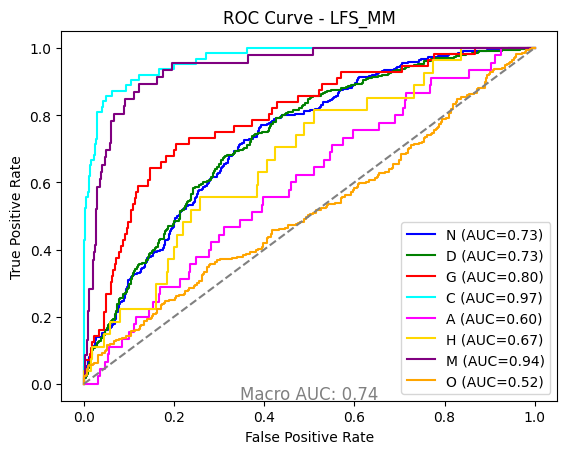

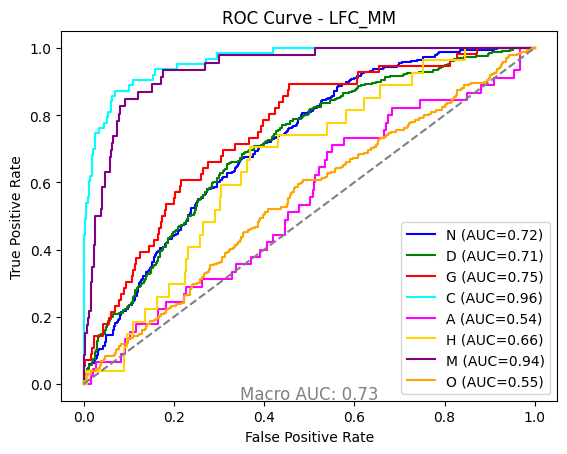

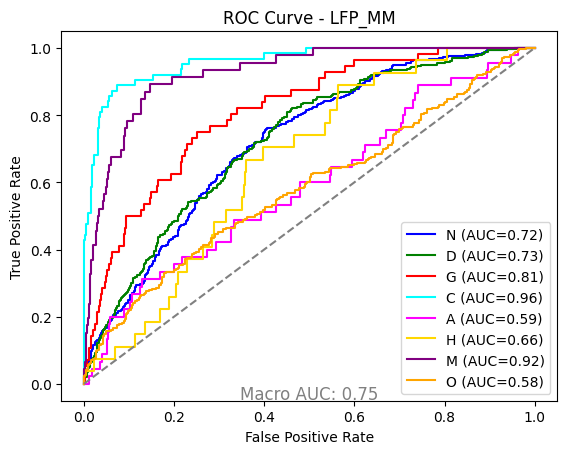

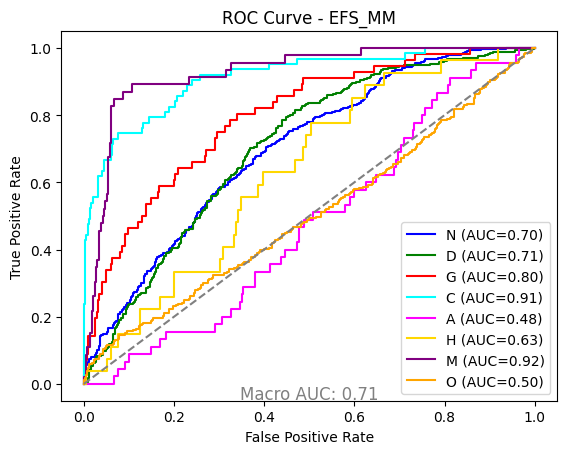

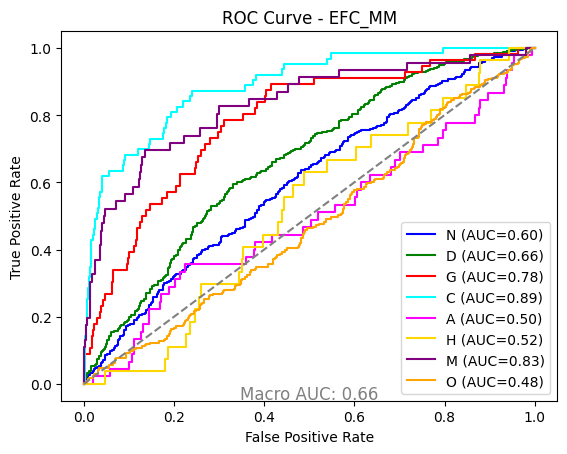

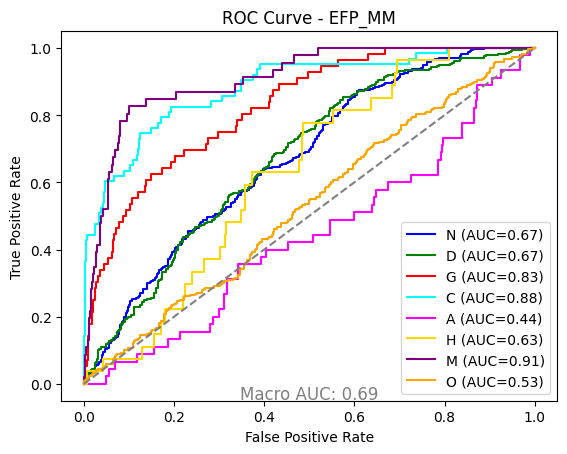

In [15]:
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'gold', 'purple', 'orange']

for model_name in class_auc:
    macro_auc_data = macro_auc[model_name][0]['test'][0]
    auc_data = class_auc[model_name][0]['test'][0]
    fpr_data = fpr[model_name][0]['test'][0]
    tpr_data = tpr[model_name][0]['test'][0]
    
    for class_idx in range(len(auc_data)):
        class_name = class_names[class_idx]
        class_color = colors[class_idx]
        plt.plot(fpr_data[class_idx], tpr_data[class_idx], label=f'{class_name} (AUC={auc_data[class_idx]:.2f})', color=class_color)

    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.text(0.5, -0.005, f'Macro AUC: {round(macro_auc_data, 2)}',
         verticalalignment='bottom', horizontalalignment='center',
         transform=plt.gca().transAxes,
         color='grey', fontsize=12)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}')
    plt.legend(loc='lower right')
    plt.show()

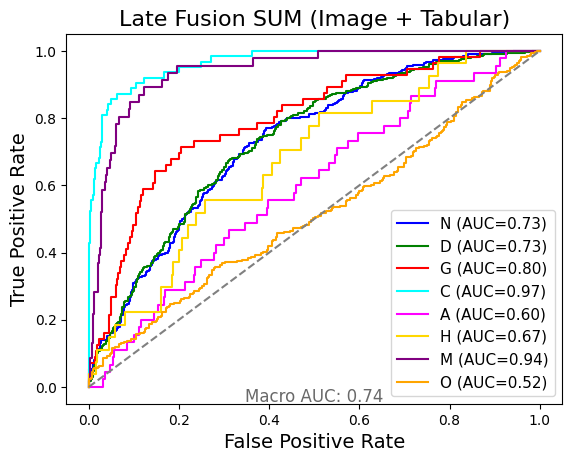

In [27]:
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'gold', 'purple', 'orange']

for model_name in class_auc:
    if model_name == 'LFS_MM':
        macro_auc_data = macro_auc[model_name][0]['test'][0]
        auc_data = class_auc[model_name][0]['test'][0]
        fpr_data = fpr[model_name][0]['test'][0]
        tpr_data = tpr[model_name][0]['test'][0]
        
        for class_idx in range(len(auc_data)):
            class_name = class_names[class_idx]
            class_color = colors[class_idx]
            plt.plot(fpr_data[class_idx], tpr_data[class_idx], label=f'{class_name} (AUC={auc_data[class_idx]:.2f})', color=class_color)
    
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
        plt.text(0.5, -0.005, f'Macro AUC: {round(macro_auc_data, 2)}',
             verticalalignment='bottom', horizontalalignment='center',
             transform=plt.gca().transAxes,
             color='dimgrey', fontsize=12)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(f'Late Fusion SUM (Image + Tabular)', fontsize=16)
        plt.legend(loc='lower right', fontsize=11)
        plt.savefig('roc_LFS_tab.png', bbox_inches='tight')
        plt.show()

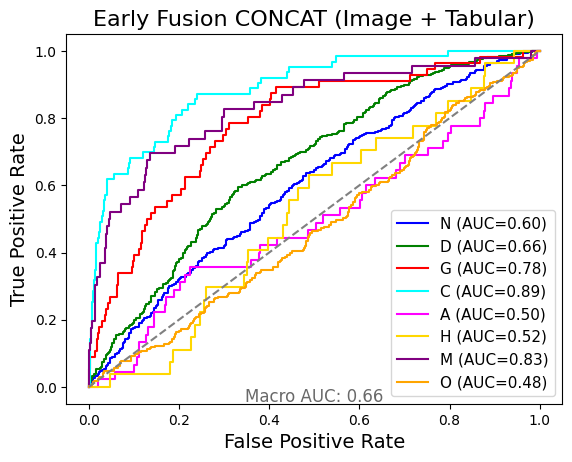

In [28]:
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'gold', 'purple', 'orange']

for model_name in class_auc:
    if model_name == 'EFC_MM':
        macro_auc_data = macro_auc[model_name][0]['test'][0]
        auc_data = class_auc[model_name][0]['test'][0]
        fpr_data = fpr[model_name][0]['test'][0]
        tpr_data = tpr[model_name][0]['test'][0]
        
        for class_idx in range(len(auc_data)):
            class_name = class_names[class_idx]
            class_color = colors[class_idx]
            plt.plot(fpr_data[class_idx], tpr_data[class_idx], label=f'{class_name} (AUC={auc_data[class_idx]:.2f})', color=class_color)
    
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
        plt.text(0.5, -0.005, f'Macro AUC: {round(macro_auc_data, 2)}',
             verticalalignment='bottom', horizontalalignment='center',
             transform=plt.gca().transAxes,
             color='dimgrey', fontsize=12)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(f'Early Fusion CONCAT (Image + Tabular)', fontsize=16)
        plt.legend(loc='lower right', fontsize=11)
        plt.savefig('roc_EFC_tab.png', bbox_inches='tight')
        plt.show()

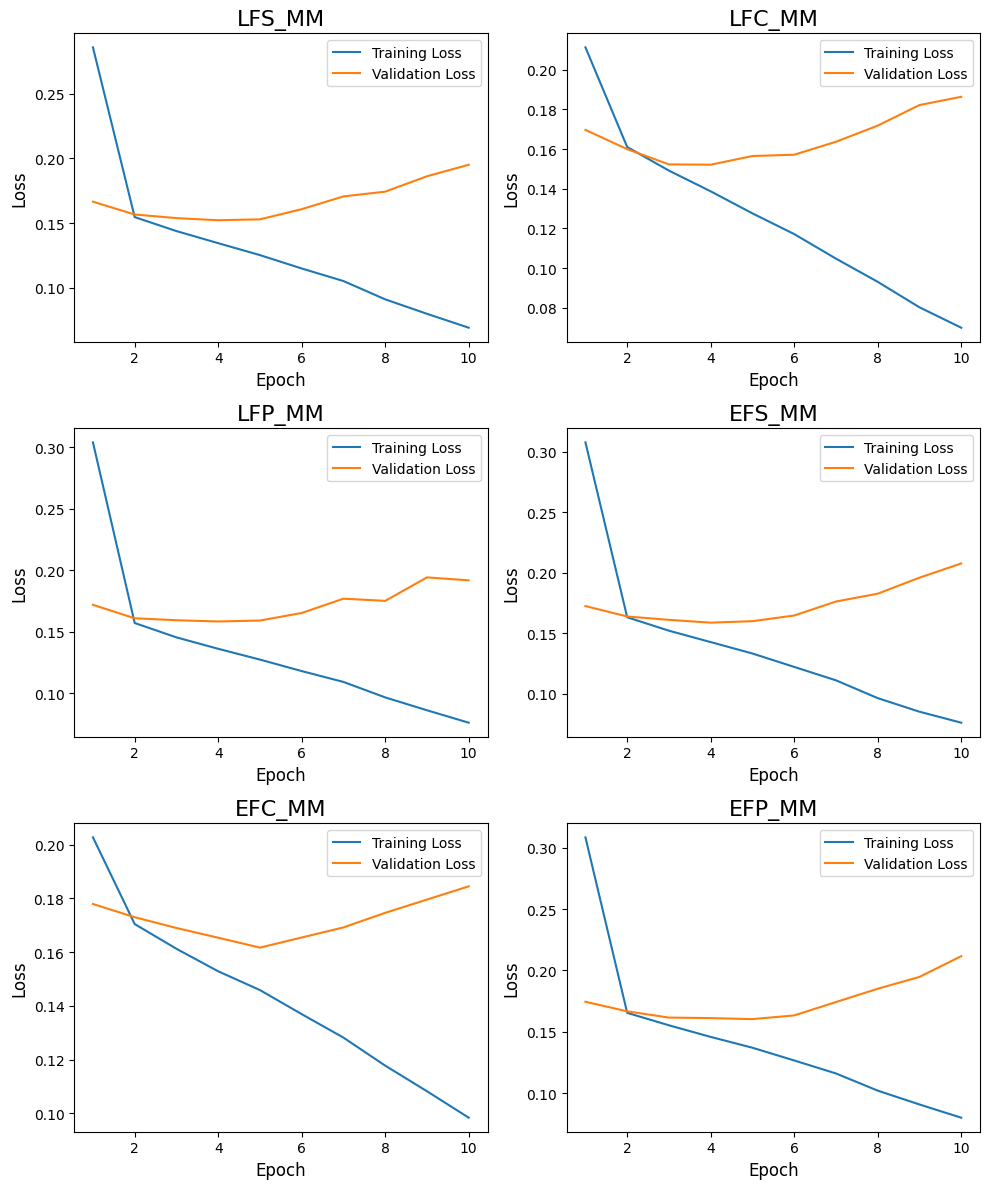

In [31]:
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))

for i, result in enumerate(saved_tab_results):
    model_name = result[:6]
    results_path = "./saved_results/bs_16_lr_1e-05/f1_results/"
    path = os.path.join(results_path, result)

    with open(path, 'rb') as f:
        results = pickle.load(f)
    
    num_epochs = 10
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].set_title(model_name, fontsize=16)
    axes[row_index, col_index].set_ylabel('Loss', fontsize=12)
    axes[row_index, col_index].set_xlabel('Epoch', fontsize=12)
    
    axes[row_index, col_index].plot(range(1, num_epochs + 1), results[0][1]['train'], label='Training Loss')
    axes[row_index, col_index].plot(range(1, num_epochs + 1), results[0][1]['validate'], label='Validation Loss')
    axes[row_index, col_index].legend()


plt.tight_layout()
plt.savefig('loss_tab.png', bbox_inches='tight')
plt.show()